In [1]:
import sys, os

sys.path.insert(0, '../../../node2vec')
sys.path.insert(0, '../../../residual2vec_')

#diable wandb logging
os.environ['DISABLE_WANDB'] = 'true'

#disable epoch level tqdm
os.environ['DISABLE_TQDM'] = 'true'
# checking if imports working
import node2vecs
from utils import snakemake_utils
from sklearn.manifold import TSNE

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [2]:
from urllib.request import urlopen
from zipfile import ZipFile

source_data_url = "http://www-personal.umich.edu/~mejn/netdata/polbooks.zip"

tmp_gml_file = "/tmp/data"
zipresp = urlopen(source_data_url)
tempzip = open("/tmp/polbooks.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
zf = ZipFile("/tmp/polbooks.zip")
zf.extractall(path = tmp_gml_file)
zf.close()

graph_data_file = tmp_gml_file + "/" + "polbooks.gml"

In [3]:
import networkx as nx 
import numpy as np 
from scipy import sparse 

G = nx.read_gml(graph_data_file)
G = nx.relabel.convert_node_labels_to_integers(
    G, first_label=0, ordering="default"
)  # first_label is the starting integer label, in this case zero
nodes = G.nodes(data=True)
labels, group_ids = np.unique([nd[1]["value"] for nd in nodes], return_inverse=True)
A = nx.adjacency_matrix(G)

deg = np.array(A.sum(axis=1)).reshape(-1)

(-0.6291011863539684,
 0.8138450138587375,
 -1.0532794402603207,
 1.1951080011107091)

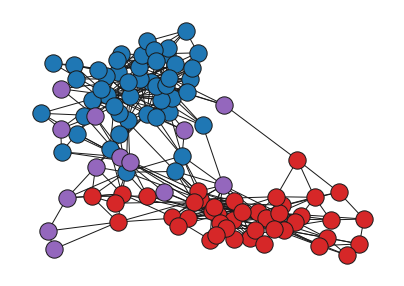

In [4]:
# %%
import seaborn as sns 
import matplotlib.pyplot as plt 
sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(7,5))

pos = nx.spring_layout(G)
node_opts = {"edgecolors": "k", "linewidths": 1.0, "ax":ax}

nx.draw_networkx_nodes(
    G, pos = pos, nodelist=np.where(group_ids == 0)[0], node_color="tab:blue", **node_opts
)
nx.draw_networkx_nodes(
    G, pos = pos, nodelist=np.where(group_ids == 1)[0], node_color="tab:red", **node_opts
)
nx.draw_networkx_nodes(
    G, pos = pos, nodelist=np.where(group_ids == 2)[0], node_color="tab:purple", **node_opts
)
nx.draw_networkx_edges(G, pos)
ax.axis("off")

In [5]:
#Parameters 
dim = 16
n_nodes = A.shape[0]
device = "cpu"

In [6]:
# Set up the embedding model
import node2vecs 

model = node2vecs.Word2Vec(
    vocab_size=n_nodes + 1,
    embedding_size=dim,
    padding_idx=n_nodes,
    learn_outvec=False, # Set True to learn out vector. Otherwise, the out-vector is copied from in-vector.
)
model = model.to(device)
# We use the most non-infomative random networks, where 
# every pair of nodes is connected with the same probability 
noise_sampler = node2vecs.utils.node_sampler.ErdosRenyiNodeSampler()
noise_sampler.fit(A) # Train the noise sampler

# We sample triplet of nodes containing one negative sample per positive sample.
loss_func = node2vecs.Node2VecTripletLoss(n_neg=1)
dataset = node2vecs.TripletDataset(
    adjmat=A,
    window_length=1,
    noise_sampler=noise_sampler,
    padding_id=n_nodes,
    buffer_size=256,
    context_window_type="double",
    epochs=1,
    negative=1,
    p = 1,
    q = 1, 
    num_walks = 20,
    walk_length = 80,
)

In [7]:
# Generate embedding 
node2vecs.train(
    model=model,
    dataset=dataset,
    loss_func=loss_func,
    batch_size=256,
    device=device,
    learning_rate=1e-3,
    num_workers=20,
)
model.eval()

# Retrieve the embedding vector. We use the in-vector. 
emb_biased = model.ivectors.weight.data.cpu().numpy()[:n_nodes, :]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 657/657 [00:06<00:00, 109.14it/s, loss=1.05]


(-48.28799343109131, 59.00025463104248, -62.44111785888672, 43.968927001953126)

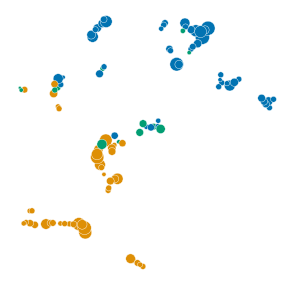

In [8]:
from sklearn.decomposition import PCA
import pandas as pd 

plot_data = []
deg = np.array(A.sum(axis=0)).reshape(-1)
xy = TSNE(n_components=2, learning_rate='auto',
          init='random', perplexity=3, random_state=0).fit_transform(emb_biased)
plot_data  = pd.DataFrame(
        {
            "x": xy[:, 0],
            "y": xy[:, 1],
            "group": group_ids,
            "model": "Biased",
            "degree": deg,
        }
    )

# %%
sns.set_style('white')
sns.set(font_scale=1.0)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5,5))

sns.scatterplot(data = plot_data, x = "x", y = "y", hue = "group", size = "degree", sizes=(10, 200), palette = sns.color_palette("colorblind", n_colors=3), ax = ax)
ax.legend().remove()
ax.axis("off")

In [9]:
def generate_embedding(A, dim, noise_sampler):
    model = node2vecs.Word2Vec(
        vocab_size=n_nodes + 1,
        embedding_size=dim,
        padding_idx=n_nodes,
        learn_outvec=False, # Set True to learn out vector. Otherwise, the out-vector is copied from in-vector.
    )
    model = model.to(device)
    noise_sampler.fit(A) # Train the noise sampler
    
    # We sample triplet of nodes containing one negative sample per positive sample.
    loss_func = node2vecs.Node2VecTripletLoss(n_neg=1)
    dataset = node2vecs.TripletDataset(
        adjmat=A,
        window_length=1,
        noise_sampler=noise_sampler,
        padding_id=n_nodes,
        buffer_size=256,
        context_window_type="double",
        epochs=1,
        negative=1,
        p = 1,
        q = 1, 
        num_walks = 20,
        walk_length = 80,
    )
    # Generate embedding 
    node2vecs.train(
        model=model,
        dataset=dataset,
        loss_func=loss_func,
        batch_size=256,
        device=device,
        learning_rate=1e-3,
        num_workers=20,
    )
    model.eval()
    
    # Retrieve the embedding vector. We use the in-vector. 
    return model.ivectors.weight.data.cpu().numpy()[:n_nodes, :]

In [10]:
config_noise_sampler = node2vecs.utils.node_sampler.ConfigModelNodeSampler()
sbm_noise_sampler=node2vecs.utils.node_sampler.SBMNodeSampler(
   group_membership=group_ids, window_length=1
)

In [11]:
emb_config = generate_embedding(A, dim, config_noise_sampler)
emb_sbm = generate_embedding(A, dim, sbm_noise_sampler)
embs = {
    "Biased":emb_biased,
    "Degree-debiased":emb_config,
    "Degree-Group-debiased":emb_sbm,
    "Degree-Group-debiased-temp":emb_sbm
}

# calculate ROC AUC score here


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 657/657 [00:04<00:00, 133.41it/s, loss=1.15]


In [12]:
# FW + N2V
embs['fw_n2v'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=False, 
                                                              node2vec=True, fairwalk=True, learn_outvec=False, model_dim=16)
#FW + DW
embs['fw_dw'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=False, 
                                                              node2vec=False, fairwalk=True, learn_outvec=False, model_dim=16)



Using existing file polbooks.gml
Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:01<00:00, 710.46it/s]
Using existing file polbooks.gml


In [13]:
# CW + N2V
embs['cw_n2v'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=True, r2v=False, 
                                                              node2vec=True, fairwalk=False, learn_outvec=False, model_dim=16)

# CW + DW
embs['cw_dw'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=True, r2v=False, 
                                                              node2vec=False, fairwalk=False, learn_outvec=False, model_dim=16)


Using existing file polbooks.gml
assigning final weights: 100%|██████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 133738.82it/s]
/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 1646.94it/s]
Using existing file polbooks.gml
assigning final weights: 100%|███████████████████████████████████████████████████████████████████████████████| 105/105 [00:00<00:00, 75983.77it/s]
/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using 

In [14]:
# RANDOM
embs['gat_dw_random'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=False, 
                                                              node2vec=False, fairwalk=False, model_name='gat', learn_outvec=False, model_dim=16)

embs['gcn_dw_random'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=False, 
                                                              node2vec=False, fairwalk=False, model_name='gcn', learn_outvec=False, model_dim=16)

embs['gat_n2v_random'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=False, 
                                                              node2vec=True, fairwalk=False, model_name='gat', learn_outvec=False, model_dim=16)

embs['gcn_n2v_random'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=False, 
                                                              node2vec=True, fairwalk=False, model_name='gcn', learn_outvec=False, model_dim=16)


Using existing file polbooks.gml


torch.Size([2, 882])
size of edge_index torch.Size([2, 882])  and size of neg_edge_index torch.Size([2, 2432])
number of common sources 105
Patience threshold: 0


Generating node embeddings:   0%|                                                                                           | 0/1 [00:01<?, ?it/s]
Using existing file polbooks.gml
/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


torch.Size([2, 882])
size of edge_index torch.Size([2, 882])  and size of neg_edge_index torch.Size([2, 2432])
number of common sources 105
Patience threshold: 0


Generating node embeddings:   0%|                                                                                           | 0/1 [00:01<?, ?it/s]
Using existing file polbooks.gml
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 2108.80it/s]


torch.Size([2, 882])
size of edge_index torch.Size([2, 882])  and size of neg_edge_index torch.Size([2, 2438])
number of common sources 105
Patience threshold: 0


Generating node embeddings:   0%|                                                                                           | 0/1 [00:01<?, ?it/s]
Using existing file polbooks.gml
/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 37689.51it/s]


torch.Size([2, 882])
size of edge_index torch.Size([2, 882])  and size of neg_edge_index torch.Size([2, 2442])
number of common sources 105
Patience threshold: 0


Generating node embeddings:   0%|                                                                                           | 0/1 [00:01<?, ?it/s]


In [15]:
# R2V

embs['gat_dw_r2v'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=True, 
                                                              node2vec=False, fairwalk=False, model_name='gat', learn_outvec=False)

embs['gcn_dw_r2v'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=True, 
                                                              node2vec=False, fairwalk=False, model_name='gcn', learn_outvec=False)

embs['gat_n2v_r2v'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=True, 
                                                              node2vec=True, fairwalk=False, model_name='gat', learn_outvec=False)

embs['gcn_n2v_r2v'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=True, 
                                                              node2vec=True, fairwalk=False, model_name='gcn', learn_outvec=False)


Using existing file polbooks.gml


torch.Size([2, 882])


../../../residual2vec_/dataset/triplet_dataset.py:151: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484801627/work/torch/csrc/utils/tensor_new.cpp:201.)
  return torch.tensor([source, dist], dtype=torch.long)


size of edge_index torch.Size([2, 882])  and size of neg_edge_index torch.Size([2, 6079])
number of common sources 105
Patience threshold: 0


Generating node embeddings:   0%|                                                                                           | 0/1 [00:01<?, ?it/s]
Using existing file polbooks.gml
/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


torch.Size([2, 882])
size of edge_index torch.Size([2, 882])  and size of neg_edge_index torch.Size([2, 6053])
number of common sources 105
Patience threshold: 0


Generating node embeddings:   0%|                                                                                           | 0/1 [00:01<?, ?it/s]
Using existing file polbooks.gml
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 36758.36it/s]


torch.Size([2, 882])
size of edge_index torch.Size([2, 882])  and size of neg_edge_index torch.Size([2, 6026])
number of common sources 105
Patience threshold: 0


Generating node embeddings:   0%|                                                                                           | 0/1 [00:01<?, ?it/s]
Using existing file polbooks.gml
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 23844.05it/s]


torch.Size([2, 882])
size of edge_index torch.Size([2, 882])  and size of neg_edge_index torch.Size([2, 6126])
number of common sources 105
Patience threshold: 0


Generating node embeddings:   0%|                                                                                           | 0/1 [00:01<?, ?it/s]


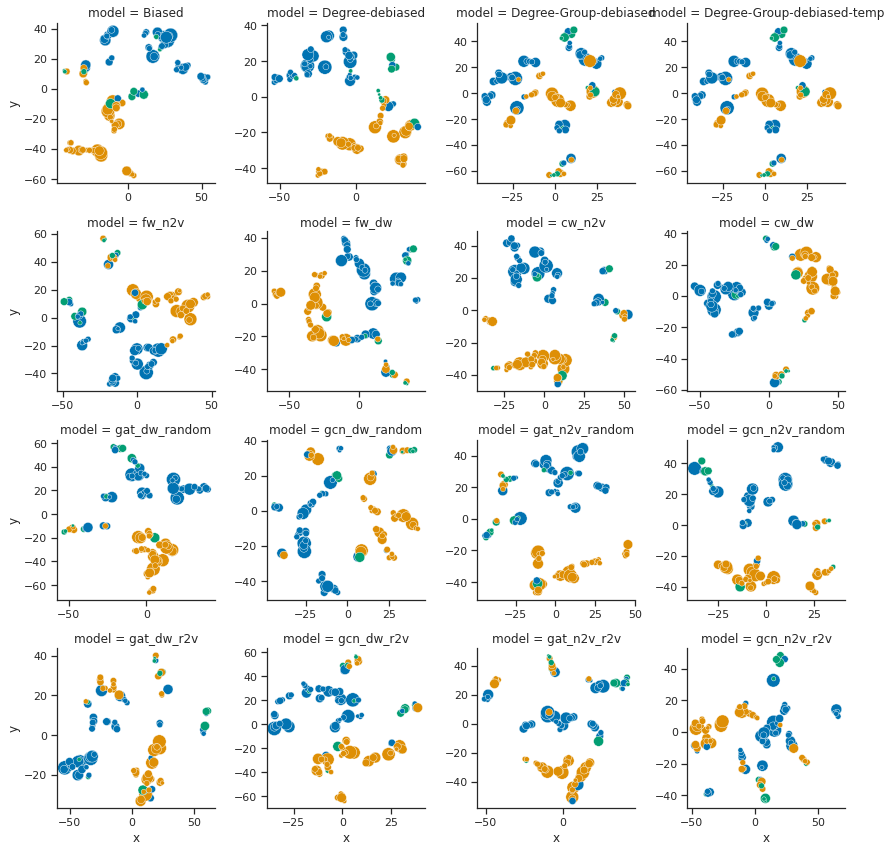

In [16]:
plot_data_all = [plot_data]

deg = np.array(A.sum(axis=0)).reshape(-1)
row = 0
for idx, (k, emb) in enumerate(embs.items()):
    emb = embs[k]
    if idx % 4 == 0: row += 1
    xy = TSNE(n_components=2, learning_rate='auto',
          init='random', perplexity=3, random_state=0).fit_transform(emb)
    plot_data_all += [
        pd.DataFrame(
            {
                "x": xy[:, 0],
                "y": xy[:, 1],
                "group": group_ids,
                "model": k,
                "degree": deg,
                "row": row
            }
        )
    ]

plot_data_all = pd.concat(plot_data_all)
#
sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
# fig, ax = plt.subplots(figsize=(7,5))

g = sns.FacetGrid(
    data=plot_data_all,
#     row="row",
    col='model',
    sharex=False,
    sharey=False,
    col_wrap=4
    
)

g.map(sns.scatterplot, "x", "y", "group", "degree", sizes=(10, 200), palette = sns.color_palette("colorblind", n_colors=3), )